In [1]:
from IPython.display import display
from IPython.display import Image
import os
from utils import * # Code shared across more than one notebook

In [29]:
output_path = "2-output_data/"

if not os.path.exists(output_path):
    os.mkdir(output_path)

# gVirtualXray vs DRRs

**Main contributors:** J. Pointon, J. Tugwell-Allsup and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to digitally reconstructed radiographs (DRRs) of a real CT scan computed with [Plastimatch](https://plastimatch.org/).

**Material and Methods:** For this experiment, we attempt to recreate a X-ray projections of the [Lungman chest phantom](https://www.kyotokagaku.com/en/products_data/ph-1_01/) with gVirtualXRay. 

In [2]:
display(Image("lungman_data/lungman.png"))

FileNotFoundError: No such file or directory: 'lungman_data/lungman.png'

FileNotFoundError: No such file or directory: 'lungman_data/lungman.png'

<IPython.core.display.Image object>

1. The CT of a chest phantom has been generated from a real scanner ahead of time. 
2. Structures in the reference CT have been segmented and labelled. 
3. The resultant surfaces from the segmentations form a virtual lungman model. 
4. We use gVirtualXRay to simulate X-ray projection on this model and 
5. compare the result with Digitally Reconstructed Radiographs (DRRs) of the original CT scan.

In [16]:
Image("doc/lungman-validation-DRR-flow.png", width=800)

**Results:** Images generated with gVirtualXray are very similar to DRRs computed with Plastimatch, despite the use of homogeneous materials in the simulation. 
MAPE is low in both cases (1.84% and 1.92%), ZNCC (99.61% and 99.83%) and SSIM (0.93 and 0.98) are high in both cases. 
It took 419 ms to compute the DRR images on GPU with Plastimatch compiled with CUDA, 37 ms with gVirtualXray. 
It corresponds to a 11x speedup.

In [30]:
fname = output_path + "/lungman-profiles-CT-mu.png"
if os.path.exists(fname):
    display(Image(fname))

**Quantitative comparisons**\
From qauntative measures we achieved: a ZNCC score of 0.977 (97.7% similarity), a MAPE/MAPD 0.293 and a SSIM score of 0.911. For reference, a good ZNCC and SSIM score is 1 and a good MAPE score is 0.

The calculations were performed on the following platform:

In [18]:
printSystemInfo()

OS:
	Linux 5.14.21-150400.24.11-default
	x86_64

CPU:
 	Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz

RAM:
	31 GB
GPU:
	Name: NVIDIA GeForce RTX 2080 Ti
	Drivers: 515.48.07
	Video memory: 11 GB


# Import packages

In [19]:
%matplotlib inline

import SimpleITK as sitk
import pandas as pd
import numpy as np
import numpy.ma as ma # Masking
from utils import *
from convertRaw import *
from gvxrPython3 import gvxr
import json2gvxr

import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'serif'#,
        #'weight' : 'bold',
         # 'size'   : 22
       }
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

from tifffile import imread, imwrite # Load/Write TIFF file

from sitk2vtk import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
import skimage

#import scipy
import os
import math
import zipfile
import datetime

import imageio

import k3d
import random
import base64
from stl import mesh
from time import sleep

In [20]:
SAVE_DATA = False
GENERATE_NEW_DATA_ALWAYS = True
DO_K3D_PLOT = True

In [21]:
DO_ARTEFACT_FILTERING_ON_GPU = True
DO_ARTEFACT_FILTERING_ON_CPU = False
number_of_projections = 1000
angular_step = 180 / number_of_projections

# Configure gVirtualXRay environment

## Create an OpenGL context and window

In [22]:
json2gvxr.initGVXR("notebook-2.json", "OPENGL")

Create an OpenGL context: 512x512


Tue Sep  6 16:32:22 2022 ---- Create window (ID: -1)
Tue Sep  6 16:32:22 2022 ---- Initialise GLFW
Tue Sep  6 16:32:22 2022 ---- Create an OpenGL window with a 3.2 context.
Tue Sep  6 16:32:22 2022 ---- Make the window's context current
Tue Sep  6 16:32:22 2022 ---- Initialise GLEW
Tue Sep  6 16:32:22 2022 ---- OpenGL vendor: NVIDIA Corporation
Tue Sep  6 16:32:22 2022 ---- OpenGL renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
Tue Sep  6 16:32:22 2022 ---- OpenGL version: 3.2.0 NVIDIA 515.48.07
Tue Sep  6 16:32:22 2022 ---- Initialise the X-ray renderer if needed and if possible


## Create a parallel photon beam

In [23]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


## Create a monochromatic spectrum

In [24]:
json2gvxr.initSpectrum();

**Create a detector array.**

In [25]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


Tue Sep  6 16:32:22 2022 ---- Initialise the renderer


In [26]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

# Load the CT scan

In [27]:
# Read the reference CT
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha")
raw_ground_truth = sitk_reader.Execute()
real_CT_in_HU = np.array(sitk.GetArrayFromImage(raw_ground_truth));

#
# Blur using CurvatureFlowImageFilter
#
# blurFilter = sitk.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# sitk_ground_truth_CT_recons_in_HU = blurFilter.Execute(raw_ground_truth)
# ground_truth_CT_recons_in_HU = np.array(sitk.GetArrayFromImage(sitk_ground_truth_CT_recons_in_HU));

# Make sure each volume has floating point precision
real_CT_in_HU = real_CT_in_HU.astype(np.single);

# Drop the first and last slices
# ground_truth_CT_recons_in_HU = ground_truth_CT_recons_in_HU[1:ground_truth_CT_recons_in_HU.shape[0] - 1]

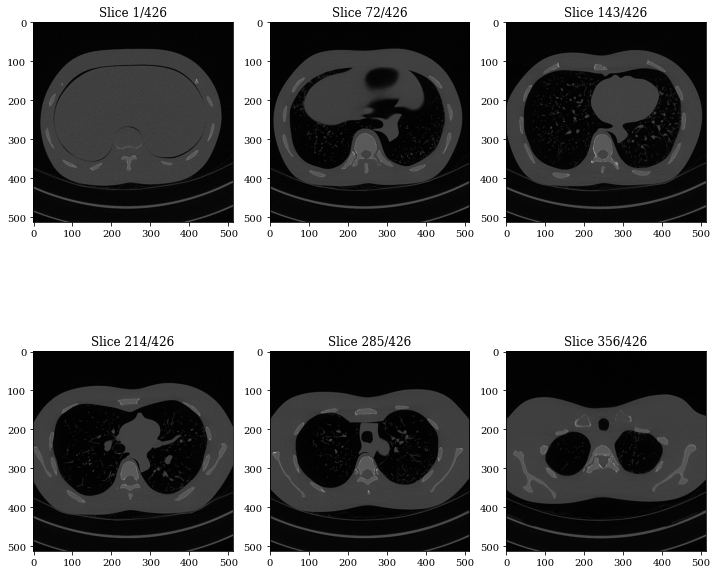

In [31]:
ncols = 3
nrows = 2

step = int(real_CT_in_HU.shape[0] / (ncols * nrows))
slices = range(0, int(real_CT_in_HU.shape[0]), step)

fig = plt.figure(figsize= (10,10))

ct_min_val = real_CT_in_HU.min()
ct_max_val = real_CT_in_HU.max()

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(real_CT_in_HU.shape[0]))
        ax.imshow(real_CT_in_HU[slice_id], cmap='gray', vmin=ct_min_val, vmax=ct_max_val)
        
plt.tight_layout()

plt.savefig(output_path + '/lungman-real_CT_in_HU.pdf')
plt.savefig(output_path + '/lungman-real_CT_in_HU.png')

In [32]:
def ShouldGenerateNew(*fnames):
    
    if (GENERATE_NEW_DATA_ALWAYS):
        return True
    
    for fname in fnames:
        if (not os.path.exists(fname)):
            return True
        
    return False

# Convert ground truth from HU to &mu;

In [33]:
fname = output_path + "/lungman-real_CT_in_mu.mha"

if ShouldGenerateNew(fname):

    #real_CT_in_mu = np.array(gvxr.convertHU2mu(real_CT_in_HU, ray_energy, "keV"))
    mu_air  =gvxr.getMuFromHU(-1000.0, 72, "keV");
    mu_water  =gvxr.getMuFromHU(0.0, 72, "keV");
    real_CT_in_HU = real_CT_in_HU.astype(np.double);
    real_CT_in_mu = ((real_CT_in_HU / 1000.0 ) * (mu_water - mu_air)) + mu_water;
  
   
    if SAVE_DATA:
      
        sitk_real_CT_in_mu = sitk.GetImageFromArray(real_CT_in_mu)
        sitk_real_CT_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])

        sitk_real_CT_in_mu.SetOrigin((-pixel_width * real_CT_in_mu.shape[2] / 2.0,
                              -pixel_width * real_CT_in_mu.shape[1] / 2.0,
                              -pixel_height * real_CT_in_mu.shape[0] / 2.0))
    
        sitk.WriteImage(sitk_real_CT_in_mu, fname, useCompression=True)

else:
    sitk_real_CT_in_mu = sitk.ReadImage(fname)
    real_CT_in_mu = sitk.GetArrayFromImage(sitk_real_CT_in_mu)

# Extract data for this experiment
The labelled volumes are provided compressed in a zip file. Use this procedure to extract the surfaces and masks needed for this notebook.

In [34]:
# Uncompress the labels
if (False == os.path.isfile("./lungman_data/segmentation-uncompressed/labels.mha")):
    with zipfile.ZipFile(  "./lungman_data/segmentation-compressed.zip", 'r') as myzip:
        myzip.extractall(  "./lungman_data/segmentation-uncompressed")

# Read the records for isovalue, average HU
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read labels
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha";
phantom = sitk.ReadImage(label_rel_path)
phantom_array = sitk.GetArrayFromImage(phantom)

In [35]:
# rd = vtk.vtkMetaImageReader();
# rd.SetFileName(label_rel_path);
# rd.Update()
# vtkLabels = rd.GetOutput();

# Create threshold filter
# threshold = vtk.vtkImageThreshold();
# threshold.SetInputData(vtkLabels);
# threshold.SetReplaceOut(0);
# threshold.ReplaceOutOn()
# threshold.ReplaceInOff();

fname_HU = output_path + "/lungman-ground_truth2-CT-in_HU.mha"
fname_mu = output_path + "/lungman-ground_truth2-CT-in_mu.mha"

ref_data = {}

if ShouldGenerateNew(fname_HU, fname_mu):
    digital_phatom_in_HU = np.zeros(phantom_array.shape, dtype=np.int16) - 1000
    digital_phatom_in_mu = np.zeros(phantom_array.shape, dtype=np.single)
else:
    sitk_digital_phatom_in_HU = sitk.ReadImage(fname_HU)
    digital_phatom_in_HU = sitk.GetArrayFromImage(sitk_digital_phatom_in_HU)

    sitk_digital_phatom_in_mu = sitk.ReadImage(fname_mu)
    digital_phatom_in_mu = sitk.GetArrayFromImage(sitk_digital_phatom_in_mu)    
    
for i in range(0, len(split_lines)):
    
    tuple_parts = split_lines[i].split('\t');
    
    structure_name = tuple_parts[2][0:-4]
    structure_isovalue = int(tuple_parts[0])

    print("Process", structure_name)
    
    # See if the surface already exists
    stl_rel_path = "./lungman_data/meshes/" + tuple_parts[2][0:-4] + ".stl";
    # if (True == os.path.isfile(stl_rel_path)): continue;
    
    # Threshold to get label
#     threshold.ThresholdBetween(structure_isovalue, structure_isovalue);
#     threshold.Update();
#     vtkIm = threshold.GetOutput();
    
#     # Extract surface and save
#     vtkSurface = extractSurface(vtkIm, structure_isovalue);
#     writeSTL(vtkSurface, stl_rel_path);
#     vtkSurface = None;
#     vtkIm = None;    

    # Threshold the phantom
    binary_mask = (phantom == structure_isovalue)
    
    # Pad the image
    filt = sitk.ConstantPadImageFilter()
    filt.SetConstant (0)
    filt.SetPadLowerBound ([1, 1, 1])
    filt.SetPadUpperBound ([1, 1, 1])
    binary_image = filt.Execute(binary_mask)               

    # Create a VTK image
    binary_array = sitk.GetArrayFromImage(binary_image)
    vtkimg = sitk2vtk(binary_image, centre=True)

    # binary_array = sitk.GetArrayFromImage(binary_image)
    min_val = binary_array.min()
    max_val = binary_array.max()

    threshold = min_val + 0.5 * (max_val - min_val)

    vtkmesh = extractSurface(vtkimg, threshold)
    del vtkimg

    writeSTL(vtkmesh, stl_rel_path)
    del vtkmesh
    
    
    # Get HU/mu

    if ShouldGenerateNew(fname_HU, fname_mu):

        kernel_radius = 2;

        # Sheets are too slim to be eroded so much
        if (structure_name.find("sheet") != -1):
            kernel_radius = 1;

        # Erode the mask
        erode = sitk.BinaryErodeImageFilter();
        erode.SetKernelRadius(kernel_radius);
        erode.SetForegroundValue(1);
        sitk_eroded_mask = erode.Execute(binary_mask);
        del erode

        eroded_mask = np.array(sitk.GetArrayFromImage(sitk_eroded_mask));
        del sitk_eroded_mask

        # Apply mask to simulated CT
        erored_test = (eroded_mask == 1)
        
        test = phantom_array == structure_isovalue
        avg_HU = np.mean(real_CT_in_HU[erored_test])
        avg_mu = np.mean(real_CT_in_mu[erored_test])

        # print("\t\t\"Material\": [\"HU\",", avg_HU, "]")
                
        ref_data[structure_name] = [avg_HU, avg_mu]
        digital_phatom_in_HU[test] = round(avg_HU)
        digital_phatom_in_mu[test] = avg_mu

Process bronchioles
Process bronchus
Process trachea
Process diaphram
Process skin
Process heart
Process ribs_spine
Process scapulas
Process sternum
Process clavicle
Process sheets_low
Process sheets_med
Process sheets_high
Process tumours_630HU
Process tumours_100HU


In [36]:
if ShouldGenerateNew(fname_HU, fname_mu):
    
    if SAVE_DATA:
        sitk_digital_phatom_in_HU = sitk.GetImageFromArray(digital_phatom_in_HU)

        sitk_digital_phatom_in_HU.SetOrigin((-pixel_width * digital_phatom_in_HU.shape[2] / 2.0,
                      -pixel_width * digital_phatom_in_HU.shape[1] / 2.0,
                      -pixel_height * digital_phatom_in_HU.shape[0] / 2.0))

        sitk_digital_phatom_in_HU.SetSpacing([pixel_width, pixel_width, pixel_height])
        sitk.WriteImage(sitk_digital_phatom_in_HU, fname_HU, useCompression=True)



        sitk_digital_phatom_in_mu = sitk.GetImageFromArray(digital_phatom_in_mu)

        sitk_digital_phatom_in_mu.SetOrigin((-pixel_width * digital_phatom_in_mu.shape[2] / 2.0,
                     -pixel_width * digital_phatom_in_mu.shape[1] / 2.0,
                      -pixel_height * digital_phatom_in_mu.shape[0] / 2.0))

        sitk_digital_phatom_in_mu.SetSpacing([pixel_width, pixel_width, pixel_height])
        sitk.WriteImage(sitk_digital_phatom_in_mu, fname_mu, useCompression=True)

## Create a phantom model from each mesh and its material

In [37]:
json2gvxr.initSamples();

Tue Sep  6 16:37:19 2022 ---- file_name:	lungman_data/meshes/bronchioles.stl	nb_faces:	5338192	nb_vertices:	16014576	bounding_box (in cm):	(-12.625, -8.3125, -13.65)	(11.8125, 7.3125, 12.81)
Tue Sep  6 16:37:20 2022 ---- file_name:	lungman_data/meshes/bronchus.stl	nb_faces:	701200	nb_vertices:	2103600	bounding_box (in cm):	(-11.375, -8.0625, -11.97)	(11.75, 6.5, 10.57)
Tue Sep  6 16:37:20 2022 ---- file_name:	lungman_data/meshes/trachea.stl	nb_faces:	88328	nb_vertices:	264984	bounding_box (in cm):	(-2.8125, -6.625, -1.68)	(3.8125, 0.5, 14.84)
Tue Sep  6 16:37:20 2022 ---- file_name:	lungman_data/meshes/diaphram.stl	nb_faces:	507436	nb_vertices:	1522308	bounding_box (in cm):	(-12.625, -9, -14.84)	(11.875, 6.3125, -8.26)
Tue Sep  6 16:37:21 2022 ---- file_name:	lungman_data/meshes/skin.stl	nb_faces:	6416748	nb_vertices:	19250244	bounding_box (in cm):	(-15.9375, -11.75, -14.84)	(15.9375, 10.75, 14.84)
Tue Sep  6 16:37:21 2022 ---- file_name:	lungman_data/meshes/heart.stl	nb_faces:	440588	

In [38]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh
    
print("There are", f"{number_of_triangles:,}", "triangles in total")

There are 19,277,756 triangles in total


## Visualise the virtual patient

In [40]:
if (DO_K3D_PLOT):
    plot = k3d.plot()
    plot.background_color = 0xffffff

    for sample in json2gvxr.params["Samples"]:

        label = sample["Label"]

        fname = sample["Path"]

         #r, g, b, a = gvxr.getAmbientColour(label)
         #R = math.floor(255*r)
         #G = math.floor(255*g)
         #B = math.floor(255*b)
         #A = math.floor(255*a)
        R = sample["Colour"][0];
        G = sample["Colour"][1];
        B = sample["Colour"][2];
        o = sample["Colour"][3];

        k3d_color = 0;
        k3d_color |= (R & 255) << 16;
        k3d_color |= (G & 255) << 8;
        k3d_color |= (B & 255);

        mesh_from_stl_file = mesh.Mesh.from_file(fname)
        opacity = o;
         #if label == "Skin":
         #    opacity = 0.2
         #else:
         #    opacity = 1
        geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                               range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                               color=k3d_color, 
                               wireframe=False, 
                               flat_shading=False,
                               name=fname,
                               opacity=opacity)

        plot += geometry   

    plot.display()
    plot.camera = [458.4242199518181, -394.5268107574361, 59.58430140683608, 93.26420522817403, -15.742963565665017, -45.88423611599179, -0.08892603121323975, 0.11140808541436767, 0.9897880578573034]

Output()

In [42]:
fname = output_path + '/lungman_model.png'
if DO_K3D_PLOT and ShouldGenerateNew(fname):

        
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)
        fp.flush();
        fp.close();

## Visualise a single projection

In [ ]:
gvxr.computeXRayImage()
gvxr.displayScene()

# Give each mesh an alpha value
alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

In [ ]:
%%capture
runtimes = []
fname = output_path + "/lungman_flat.mha"
if ShouldGenerateNew(fname):


    gvxr.disableArtefactFiltering()

    if DO_ARTEFACT_FILTERING_ON_GPU:
        gvxr.enableArtefactFilteringOnGPU()
    elif DO_ARTEFACT_FILTERING_ON_CPU:
        gvxr.enableArtefactFilteringOnCPU()

    raw_projections = [];
    angles = [];
    runtimes = []

    # Create a GIF file
    writer = None
    fname_gif = output_path + "/lungman_acquisition.gif"

    if not os.path.exists(fname_gif):
        writer = imageio.get_writer(fname_gif, mode='I')

    # Save the transformation matrix
    transformation_matrix_backup = gvxr.getSceneTransformationMatrix()

    rotation_axis = json2gvxr.params["Detector"]["UpVector"]

    for angle_id in range(0, number_of_projections):

        # Add the rotation angle, starting from 0
        angles.append(angle_id * angular_step)

        # Compute an X-ray image
        # xray_image = np.array(gvxr.computeXRayImage());
        start_time = datetime.datetime.now()

        xray_image = gvxr.computeXRayImage()

        # if xray_image.shape != [208, 1062]:
        #     xray_image = resize(xray_image, [208, 1062])

        # xray_image = np.array(gvxr.computeXRayImage());

        end_time = datetime.datetime.now()
        delta_time = end_time - start_time
        runtimes.append(delta_time.total_seconds() * 1000)

        # Add to the set of projections
        raw_projections.append(xray_image)

        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 30:
                screenshot = gvxr.takeScreenshot()

                plt.figure(figsize= (10,10))
                plt.title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')

                plt.tight_layout()

                plt.savefig('temp.png')            
                plt.close()


                image = imageio.imread("temp.png")
                writer.append_data(image)

        # Rotate the sample
        gvxr.rotateScene(angular_step, rotation_axis[0], rotation_axis[1], rotation_axis[2])

    # We're done with the writer
    if writer is not None:
        writer.close()
        os.remove("temp.png")

    # Convert to numpy arrays
    raw_projections = np.array(raw_projections)

    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(transformation_matrix_backup)

    # Update the rendering
    gvxr.displayScene();

In [ ]:
if (len(runtimes) > 0):
    runtime_avg = round(np.mean(runtimes))
    runtime_std = round(np.std(runtimes))
else:
    runtime_avg = -1;
    runtime_std = 0;

In [ ]:
with open(output_path + '/lungman_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500))

# Correct flat-field

Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.



In [ ]:
if ShouldGenerateNew(fname):
    
    corrected_projections = flatFieldCorrection(raw_projections)
    corrected_projections = np.array(corrected_projections).astype(np.single)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(corrected_projections)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)
        del raw_projections # Not needed anymore
    
else:
    temp = sitk.ReadImage(fname)
    corrected_projections = sitk.GetArrayFromImage(temp)

# Negative log normalisation

In [ ]:
fname = output_path + "/lungman_minus_log_projs.mha"

if ShouldGenerateNew(fname):

    minus_log_projs = minusLog(corrected_projections)

    if SAVE_DATA:
        sitk_image = sitk.GetImageFromArray(minus_log_projs)
        sitk_image.SetSpacing([pixel_width, pixel_height, angular_step])
        sitk.WriteImage(sitk_image, fname, useCompression=True)

else:
    temp = sitk.ReadImage(fname)
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
del corrected_projections # Not needed anymore

Display the images

In [ ]:
proj_min = minus_log_projs.min()
proj_max = minus_log_projs.max()

Draw the projection

In [ ]:
ncols = 4
nrows = 2

step = int(minus_log_projs.shape[0] / (ncols * nrows))
slices = range(0, int(minus_log_projs.shape[0]), step)

fig = plt.figure(figsize= (20, 7))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Projection " + str(slice_id + 1) + "/" + str(minus_log_projs.shape[0]) + "\nat $" + "{:.2f}".format(angles[slice_id]) + "\degree$")
        ax.imshow(skimage.transform.rotate(minus_log_projs[slice_id], 180),
                  cmap='gray',
                  vmin=proj_min,
                  vmax=proj_max)

plt.tight_layout()


plt.savefig(output_path + '/lungmand-simulated-projs.pdf')
plt.savefig(output_path + '/lungmand-simulated-projs.png')

## Optimise Plastimatch centre
**Use objective function to find optimimum centre. i.e. register the DRR onto the radiograph**

In [ ]:
from pymoo.util.misc import stack
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from threading import Thread
from sklearn.metrics import mean_absolute_percentage_error

def normImage(image_to_normalise):
    image_to_normalise -= np.mean(image_to_normalise);
    stddev = np.std(image_to_normalise);
    if (stddev == 0): stddev = 0.0001;
    image_to_normalise/= stddev;
    
def measure(truth, predict):
    N = 1.0;
    dims = np.shape(truth);
    for i in range(0, len(dims)):
        N *= dims[i];
    if (N == 0): return -1, -1, -1, -1, -1;
    
    zncc_denom = N * np.std(truth) * np.std(predict);
    if (zncc_denom == 0): zncc_denom = 0.00001;
        
    sub = truth - predict;
    
    mae_score = np.sum(np.abs(sub)) / N;
    zncc_score =  np.sum( (truth  - np.mean(truth)) *(predict - np.mean(predict))) / zncc_denom;
    rmse_score =  np.sqrt(np.sum(np.power(sub, 2)) / N)
    mape_score = mean_absolute_percentage_error(truth, predict);
    ssim_score = ssim(truth, predict);
    return mae_score, zncc_score, rmse_score, mape_score, ssim_score

def objective(cx, cy):
        DRR = doLungmanDRRNumpy(g_NRM[0], g_NRM[1], g_NRM[2], 
                           cx, cy, 
                            "DRR_", 
                            g_XRay.shape[1], g_XRay.shape[0]
                            
                           );
        DRR = DRR.astype(np.single);
        normImage(DRR);
        mae, zncc, rmse, mape, ssim = measure(g_XRay, DRR);
        zncc = 1.0 - ((zncc + 1.0) /2.0);
        ssim = 1.0 - ssim;
        row = []
    
        row.append(mae);
        row.append(zncc);
        row.append(rmse);
        row.append(mape);
        row.append(ssim);
        return row;

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=5,
                         n_constr=0,
                         xl=np.array([0, -g_XRay.shape[0]]),
                         xu=np.array([g_XRay.shape[1],0])
                         )
    
  
      
    
    def _evaluate(self, X, out, *args, **kwargs):
            objs = []
            for tuple in X:
                objs.append(objective(tuple[0], tuple[1]));

            out["F"] = objs;
        
        
import time
from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

termination = get_termination("n_gen", 100)


algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=False
)
#normImage(xray_AP);
#normImage(xray_RL);

from pymoo.optimize import minimize

**Generate optimise result if not done so already**

In [ ]:
import pymoo.core.result;

fname_nsga_rl_X = output_path + "/R-L-res-nsga2-X.dat";
fname_nsga_rl_F = output_path + "/R-L-res-nsga2-F.dat";
fname_nsga_ap_X = output_path + "/A-P-res-nsga2-X.dat";
fname_nsga_ap_F = output_path + "/A-P-res-nsga2-F.dat";

r_l_res_exists = not ShouldGenerateNew(fname_nsga_rl_X, fname_nsga_rl_F);
    
a_p_res_exists = not ShouldGenerateNew(fname_nsga_ap_X, fname_nsga_ap_F);

res_ap = pymoo.core.result.Result();
res_rl = pymoo.core.result.Result();

minus_log_proj_rl = np.copy(np.flip(minus_log_projs[(number_of_projections) // 2]));
minus_log_proj_ap = np.copy(np.flip(minus_log_projs[len(minus_log_projs) - 1]));
normImage(minus_log_proj_rl);
normImage(minus_log_proj_ap);
s="Time taken {t} seconds.";

if (r_l_res_exists):
    print("Getting R-L result from file");
    res_rl.X = np.loadtxt(fname_nsga_rl_X)
    res_rl.F = np.loadtxt(fname_nsga_rl_F)
else:
    print("Optimising R-L");
    g_NRM = [1, 0, 0]
    g_XRay = minus_log_proj_rl;
  
    problem = MyProblem();

    t_start = time.time();
    res_rl = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt(fname_nsga_rl_X, res_rl.X)
    np.savetxt(fname_nsga_rl_F, res_rl.F)

if (a_p_res_exists):
    print("Getting A-P result from file");
    res_ap.X = np.loadtxt(fname_nsga_ap_X)
    res_ap.F = np.loadtxt(fname_nsga_ap_F)
else:
    print("Optimising A-P");
    g_NRM = [0, -1, 0]
    g_XRay = minus_log_proj_ap;
    
    problem = MyProblem();

    t_start = time.time();
    res_ap = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

    t_end = time.time();
    print(s.format(t=(t_end - t_start)));
    
    np.savetxt(fname_nsga_ap_X, res_ap.X)
    np.savetxt(fname_nsga_ap_F, res_ap.F)

In [ ]:

print("Optimum c for right to left", f"{res_rl.X[0][0]:.2f}", ",", f"{ res_rl.X[0][1]:.2f}")
print("Optimum c for anterior to posterior", f"{res_ap.X[0][0]:.2f}", ",", f"{ res_ap.X[0][1]:.2f}")

runtimes_drr_rl = []
runtimes_drr_ap = []

for i in range(50):
    start_time = datetime.datetime.now()

    DRR_RL = doLungmanDRRNumpy(1, 0, 0, 
                              res_rl.X[0][0], res_rl.X[0][1], 
                                "DRR_RL" 
                               );

    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes_drr_rl.append(delta_time.total_seconds() * 1000)

    start_time = datetime.datetime.now()

    DRR_AP = doLungmanDRRNumpy(0, -1, 0,
                                 res_ap.X[0][0], res_ap.X[0][1], 
                                    "DRR_AP" 
                                   );

    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes_drr_ap.append(delta_time.total_seconds() * 1000)

normImage(DRR_RL)
normImage(DRR_AP)
displayLinearPowerScales(DRR_RL,  "Lungman DRR (Right to left)", output_path + "/R_L_lungman_radiograph");
displayLinearPowerScales(DRR_AP,  "Lungman DRR (Anterior to posterior)", output_path + "/A_P_lungman_radiograph");

In [ ]:
if (len(runtimes_drr_rl) > 0):
    runtimes_drr_rl_avg = round(np.mean(runtimes_drr_rl))
    runtimes_drr_rl_std = round(np.std(runtimes_drr_rl))
else:
    runtimes_drr_rl_avg = -1;
    runtimes_drr_rl_std = 0;

In [ ]:
if (len(runtimes_drr_ap) > 0):
    runtimes_drr_ap_avg = round(np.mean(runtimes_drr_ap))
    runtimes_drr_ap_std = round(np.std(runtimes_drr_ap))
else:
    runtimes_drr_ap_avg = -1;
    runtimes_drr_ap_std = 0;

## Comparison the analytic simulation with the ground truth data

### Quantitative validation

Compute image metrics between the two simulated images:

1. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
2. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of ZNCC is 100%, and SSIM 1.

Note than the [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), is not used due to 1) zero values in the ground truth, and 2)  values are very smalls. Using the MAPE would lead to large errors for these reasons.

In [ ]:
def compare(ref_image, test_image):

    ZNCC = np.mean((ref_image - ref_image.mean()) / ref_image.std() * (test_image - test_image.mean()) / test_image.std())
    print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

    offset1 = min(ref_image.min(), test_image.min())
    offset2 = 0.1 * (ref_image.max() - ref_image.min())
    MAPE = mape(ref_image.flatten() - offset1 + offset2, test_image.flatten() - offset1 + offset2)
    print("MAPE:", "{0:0.2f}".format(100 * MAPE) + "%")

    SSIM = ssim(ref_image, test_image, data_range=ref_image.max() - ref_image.min())
    print("SSIM:", "{0:0.2f}".format(SSIM))
    
    return ZNCC, MAPE, SSIM

**Medical orientations with plastimatch.**

In [ ]:
print('R-L:')
ref_proj = DRR_RL
test_proj = minus_log_proj_rl
ZNCC_DRR_RL, MAPE_DRR_RL, SSIM_DRR_RL = compare(ref_proj, test_proj)
fullCompareImages(ref_proj,
                  test_proj,
                  "gVirtualXRay",
                  output_path + "/lungman-compare-projs-plastimatch-rl",
                  False,
                  ref_proj.min(), ref_proj.max())
print('\nA-P:')

ref_proj = DRR_AP
test_proj = minus_log_proj_ap
ZNCC_DRR_AP, MAPE_DRR_AP, SSIM_DRR_AP = compare(ref_proj, test_proj)
fullCompareImages(ref_proj,
                  test_proj,
                  "gVirtualXRay",
                  output_path + "/lungman-compare-projs-plastimatch-ap",
                  False,
                  ref_proj.min(), ref_proj.max())

In [ ]:
ref_diag = np.diag(ref_proj)
test_diag = np.diag(test_proj)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ref_diag, label="DRR from phantom")
ax.plot(test_diag, label="Projection simulated using gVirtualXRay")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.legend()

Print a row of the table for the paper

In [ ]:
print("Lungman AP view & Plastimatch DRR & " + 
      "{0:0.2f}".format(100 * MAPE_DRR_AP) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_DRR_AP) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_DRR_AP) + "    &    $" +
      str(DRR_AP.shape[1]) + " \\times " + str(DRR_AP.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " + str(runtimes_drr_ap_avg) + " \\pm " + str(runtimes_drr_ap_std) + "    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

In [ ]:
print("Lungman RL view & Plastimatch DRR & " + 
      "{0:0.2f}".format(100 * MAPE_DRR_RL) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_DRR_RL) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_DRR_RL) + "    &    $" +
      str(DRR_AP.shape[1]) + " \\times " + str(DRR_AP.shape[0]) + "$    &    " +
      str(number_of_triangles) + "    &    " + str(runtimes_drr_rl_avg) + " \\pm " + str(runtimes_drr_rl_std) + "    & " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")